# Machine Learning Project

## Setting up data

### Libraries used

In [56]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sbr
from datetime import datetime
import matplotlib.pyplot as plt
import random
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

### DataFrame import

In [2]:
# Read csvs
train_df = gpd.read_file('train.geojson', index_col=0)

In [6]:
train_original = train_df

## Dealing with given data

In [7]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
                   'Mega Projects': 5}
change_status_map = {'Prior Construction': 3, 'Greenland': 0, 'Land Cleared': 1, 'Excavation': 2, 'Materials Dumped': 4,
                     'Materials Introduced': 5, 'Construction Started': 6, 'Construction Midway': 7, 'Construction Done': 8, 'Operational': 9}

Here, we explode the data and save it separately to use one-hot encoding. Then, we get rid of duplicates and concatenate with the dataframe.

In [8]:
train_df.loc[train_df['urban_type'] == 'N,A', 'urban_type'] = 'None_urban'
train_df.loc[train_df['geography_type'] == 'N,A', 'geography_type'] = 'None_geo'
train_df[['urban_type', 'geography_type']] = train_df[['urban_type', 'geography_type']].apply(lambda x: x.str.split(','))

train_df_ex = train_df[['index','urban_type','geography_type']]

train_df_ex = train_df_ex.explode('urban_type')
train_df_ex = train_df_ex.explode('geography_type')

In [9]:
train_df_ex = pd.get_dummies(train_df_ex, columns=['urban_type', 'geography_type'], prefix=['urban', 'geography'])

In [10]:
train_df_ex = train_df_ex.groupby(train_df_ex['index']).sum()

In [11]:
train_df = pd.concat([train_df, train_df_ex], axis=1)

Now we replace None values by the mean value of the one-hot encoded date, rounding up (or down) to the nearest integer.

In [12]:
for class_name in ['Demolition', 'Road', 'Residential', 'Commercial', 'Industrial', 'Mega Projects']:
    for urban in ['Dense Urban','Industrial','Rural','Sparse Urban','Urban Slum']:
        mean = train_df[train_df['change_type'] == class_name]['urban_'+urban].mean()
        train_df.loc[(train_df['urban_None_urban'] == 1) & (train_df['change_type'] == class_name), 'urban_type'] = np.round(mean)
    for geo in ['Barren Land','Coastal','Dense Forest','Desert','Farms','Grass Land','Hills','Lakes','River','Snow','Sparse Forest']:
        mean = train_df[train_df['change_type'] == class_name]['geography_'+geo].mean()
        train_df.loc[(train_df['geography_None_geo'] == 1) & (train_df['change_type'] == class_name), 'geography_type'] = np.round(mean)

train_df.drop(columns=['geography_None_geo','urban_None_urban'], inplace=True)
train_df.drop(columns=['geography_type','urban_type'], inplace=True)

Here, we substitute the dates and statuses by numbers.

In [13]:
train_df['change_type'] = train_df['change_type'].apply(lambda x: change_type_map[x])

for date in range(5):
    train_df['change_status_date'+str(date)] = train_df['change_status_date'+str(date)].apply(lambda x: change_status_map[x] if (x is not None) else np.nan)  
    train_df['date'+str(date)] = train_df['date'+str(date)].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').toordinal() if (x is not None) else np.nan)

We drop all samples with NaN values in the image related data.

In [14]:
features_drop = []
for date in range(5):
    for color in ['red','green','blue']:
        for stat in ['std','mean']:
            features_drop = np.append(['img_'+color+'_'+stat+'_date'+str(date+1)], features_drop)
    features_drop = np.append(['date'+str(date)], features_drop)
    features_drop = np.append(['change_status_date'+str(date)], features_drop)

train_df.dropna(axis=0, subset=features_drop, inplace=True)

In [15]:
train_df.isnull().sum().sum()

0

## New features: area and perimeter of the polygon
We calculate the polygon area, perimeter and use the centroid to find the country. This creates three new features - 'area','perimeter' and 'country'

### Area and perimeter

In [17]:
train_area = np.asarray(train_df[['geometry']].area).reshape(-1, 1)
train_per = np.asarray(train_df[['geometry']].length).reshape(-1, 1)

train_df["area"] = train_area
train_df["perimeter"] = train_per

<ipython-input-17-1305a5afd736>:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  train_area = np.asarray(train_df[['geometry']].area).reshape(-1, 1)
<ipython-input-17-1305a5afd736>:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  train_per = np.asarray(train_df[['geometry']].length).reshape(-1, 1)


### Extracting the geographical information from the point coordinates
We use the k-means method to group data that is geographically close.
First, we define a function to extract the latitude and longitude of the polygon centroid.

In [18]:
def get_centroid_lat(row):
    center = row['geometry'].centroid.xy[1][0]
    return center

def get_centroid_lon(row):
    center = row['geometry'].centroid.xy[0][0]
    return center

Now, we separate the latitude and longitude data into a separate data frame.

In [19]:
train_df_geo = pd.DataFrame()
train_df_geo['Lat'] = train_df.apply(get_centroid_lat, axis=1)
train_df_geo['Lon'] = train_df.apply(get_centroid_lon, axis=1)

With this, we apply the k-means method to cluster the different data groups. We include here the elbow method to chose the best k value for the method. Then, we add the respective cluster label to the train dataframa.

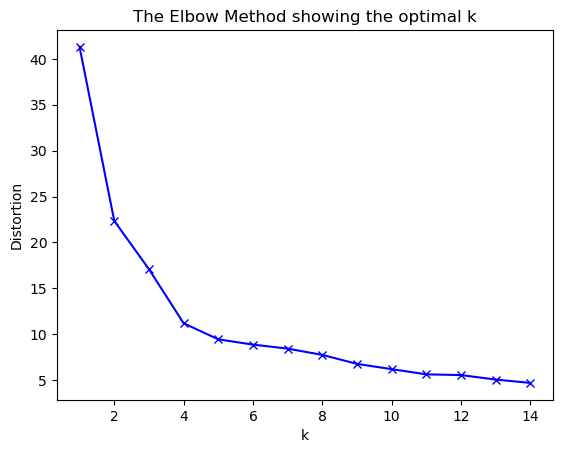

In [20]:
X = train_df_geo

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [115]:
features_nan =[]
for date in ['1','2','3','4','5']:
    for color in ['green','red','blue']:
        for value in ['std','mean']:
            features_nan = np.append(['img_'+color+'_'+value+'_date'+date], features_nan)
for date in ['0','1','2','3','4']:
    features_nan = np.append(['date'+date], features_nan)
    features_nan = np.append(['change_status_date'+date], features_nan)

features_nan

array(['change_status_date4', 'date4', 'change_status_date3', 'date3',
       'change_status_date2', 'date2', 'change_status_date1', 'date1',
       'change_status_date0', 'date0', 'img_blue_mean_date5',
       'img_blue_std_date5', 'img_red_mean_date5', 'img_red_std_date5',
       'img_green_mean_date5', 'img_green_std_date5',
       'img_blue_mean_date4', 'img_blue_std_date4', 'img_red_mean_date4',
       'img_red_std_date4', 'img_green_mean_date4', 'img_green_std_date4',
       'img_blue_mean_date3', 'img_blue_std_date3', 'img_red_mean_date3',
       'img_red_std_date3', 'img_green_mean_date3', 'img_green_std_date3',
       'img_blue_mean_date2', 'img_blue_std_date2', 'img_red_mean_date2',
       'img_red_std_date2', 'img_green_mean_date2', 'img_green_std_date2',
       'img_blue_mean_date1', 'img_blue_std_date1', 'img_red_mean_date1',
       'img_red_std_date1', 'img_green_mean_date1', 'img_green_std_date1'],
      dtype='<U32')

In [111]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(train_df_geo)
labels = kmeans.labels_
train_df['geo_cluster'] = labels
train_df_geo['geo_cluster'] = labels
cluster_groups = train_df_geo.groupby('geo_cluster').mean()

train_df.drop(columns=['geometry'], inplace=True)
cluster_groups

ValueError: Length of values (292758) does not match length of index (296146)

To better visualize, we plot a world map with the centroids found.

In [22]:
fig = px.scatter_geo(cluster_groups, lat='Lat', lon='Lon')
fig.show()

## Time series data

### Sorting function
This function will sort every row to put the dates in ascending order, changing every other time-dependent feature aswell.

In [ ]:
def sort_feature(row):
    total_list = []

    for color in ['green','red','blue']:
        for feature in ['mean', 'std']:
            y = [row['img_'+color+'_'+feature+'_date1'],row['img_'+color+'_'+feature+'_date2'],
                row['img_'+color+'_'+feature+'_date3'],row['img_'+color+'_'+feature+'_date4'],row['img_'+color+'_'+feature+'_date5']]
            total_list.append(y)

    total_list.append([row['change_status_date0'],row['change_status_date1'],row['change_status_date2'],row['change_status_date3'],row['change_status_date4']])

    x = [row['date0'],row['date1'],row['date2'],row['date3'],row['date4']]
    total_list.append(x)
    zipped = [list(row) for row in zip(*total_list)]

    sorted_zipped = sorted(zipped, key=lambda x: x[-1])
    return list(zip(*sorted_zipped))

In [54]:
all_lists = [[]]
i = 0
for date in range(5):
    all_lists[i] = list(train_df[train_df['date0'] == train_df['date0'].unique()[0]]['date'+str(date)])
    i = i + 1
    all_lists[i] = list(train_df[train_df['date0'] == train_df['date0'].unique()[0]]['change_status_date'+str(date)])
    i = i + 1
    for color in ['green','red','blue']:
        for feature in ['mean', 'std']:
            all_lists[i] = list(train_df[train_df['date0'] == train_df['date0'].unique()[0]]['img_'+color+'_'+feature+'_date'+str(date+1)])
            i = i + 1
            all_lists[i] = list(train_df[train_df['date0'] == train_df['date0'].unique()[0]]['img_'+color+'_'+feature+'_date'+str(date+1)])
            i = i + 1

zipped = [row for row in zip(*all_lists)]
sorted_zipped = sorted(zipped, key=lambda x: x[0])

333

### Get slope function
This function will get the slope of a given feature base on the feature's progression overtime. It is used only after the data is already sorted.

In [ ]:
def get_slope(row, feature='status'):
    index ={'green_mean':0,'green_std':1,'red_mean':2,'red_std':3,'blue_mean':4,'blue_std':5,'status':6}
    x = np.array(sort_feature(row)[-1]).reshape(-1,1)
    y = sort_feature(row)[index[feature]]
    model = LinearRegression().fit(x,y)
    slope = model.coef_[0]
    return slope

### Time dependent features translated into linear slopes
Every time dependent feature is trainslated into a slope and then dropped.

In [ ]:
index =['green_mean','green_std','red_mean','red_std','blue_mean','blue_std','status']
for i in range(7):
    feature = index[i]
    train_df[feature] = train_df.apply(lambda row: get_slope(row, feature=feature),axis=1)

for date in ['1','2','3','4','5']:
    for color in ['green','red','blue']:
        for value in ['std','mean']:
            train_df.drop(columns=['img_'+color+'_'+value+'_date'+date], inplace=True)
for date in ['0','1','2','3','4']:
    train_df.drop(columns=['date'+date], inplace=True)
    train_df.drop(columns=['change_status_date'+date], inplace=True)

## Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif

X = train_df.drop('change_type', axis=1)
y = train_df['change_type']

# Apply SelectKBest with the f_regression scoring function
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)

# Get the 10 best features and their scores
scores = selector.scores_
best_features = X.columns[selector.get_support()]

print("Best features:", best_features)
print("Scores:", scores[selector.get_support()])

In [ ]:
X = train_df.drop('change_type', axis=1)
y = train_df['change_type']

# using f-classif
selector = SelectPercentile(f_classif, percentile=40)
selector.fit(X, y)
X_new = selector.transform(X)

# Get the 10 best features and their scores
scores = selector.scores_
best_features = X.columns[selector.get_support()]

print("Best features:", best_features)
print("Scores:", scores[selector.get_support()])

## Exporting the final treated data

In [110]:
train_df = gpd.read_file('train.geojson', index_col=0)

In [78]:
train_df_s = train_df.iloc[random.sample(range(0, train_df.shape[0]), 1000),:]

In [109]:
from treat_data import TreatData

treat_data = TreatData(train_df, type_data='dataframe')
treat_data.df

,urban_type,geography_type,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_mean_date2,...,date1,change_status_date1,date2,change_status_date2,date3,change_status_date3,date4,change_status_date4,index,geometry
135678,NaN,NaN,Residential,102.505263,92.879211,86.805526,31.522164,29.289492,29.709441,118.385000,...,18-02-2017,Land Cleared,20-05-2016,Greenland,24-03-2018,Construction Done,24-03-2019,Construction Done,135678,"POLYGON ((100.31535 20.57315, 100.31519 20.573..."
265313,NaN,NaN,Demolition,65.418279,62.094618,76.919147,27.774697,23.759519,22.736928,90.412326,...,10-03-2018,Prior Construction,15-04-2014,Prior Construction,17-06-2017,Prior Construction,17-12-2015,Prior Construction,265313,"POLYGON ((121.03432 32.08196, 121.03444 32.081..."
27778,NaN,NaN,Commercial,207.192829,199.084650,188.192439,2.327114,2.324917,2.377395,210.567720,...,17-12-2016,Construction Started,21-04-2019,Construction Done,24-05-2020,Construction Done,30-03-2018,Construction Midway,27778,"POLYGON ((51.59885 25.21476, 51.59884 25.21331..."
34885,NaN,NaN,Residential,85.307630,84.643411,65.667891,44.078090,38.564735,32.909651,88.825785,...,07-05-2017,Prior Construction,18-12-2018,Prior Construction,19-02-2015,Prior Construction,29-03-2020,Prior Construction,34885,"POLYGON ((-81.54189 28.40137, -81.54190 28.401..."
95396,NaN,NaN,Demolition,102.846481,95.136282,90.805685,59.621691,53.711453,46.425661,158.079830,...,05-12-2019,Greenland,12-03-2019,Greenland,24-02-2016,Land Cleared,31-03-2013,Prior Construction,95396,"POLYGON ((119.68176 31.72808, 119.68180 31.727..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190945,NaN,NaN,Residential,110.104072,110.488688,114.316742,12.910869,13.094371,12.272514,66.248869,...,12-01-2015,Greenland,13-12-2015,Greenland,18-02-2020,Construction Done,25-01-2018,Construction Done,190945,"POLYGON ((73.00910 19.13037, 73.00911 19.13033..."
48715,NaN,NaN,Commercial,62.457419,57.112243,68.870777,34.170547,35.974165,33.615861,79.283786,...,08-02-2015,Construction Done,11-06-2016,Construction Done,24-03-2019,Construction Done,24-08-2017,Construction Done,48715,"POLYGON ((117.24496 39.20999, 117.24515 39.209..."
214046,NaN,NaN,Residential,132.963599,108.767170,95.419643,19.720246,17.498706,16.077307,108.368132,...,09-12-2016,Greenland,12-03-2020,Construction Done,21-01-2018,Greenland,22-03-2015,Land Cleared,214046,"POLYGON ((90.33938 23.75843, 90.33939 23.75829..."
292925,NaN,NaN,Residential,134.896036,124.512243,118.993976,40.294850,39.438129,37.963948,112.366498,...,15-08-2017,Prior Construction,21-05-2020,Prior Construction,25-08-2014,Prior Construction,25-11-2018,Prior Construction,292925,"POLYGON ((77.11592 28.51331, 77.11606 28.51330..."


In [108]:
treat_data.clean()

AttributeError: 'function' object has no attribute 'df'

In [106]:
treat_data.df

,urban_type,geography_type,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_mean_date2,...,date1,change_status_date1,date2,change_status_date2,date3,change_status_date3,date4,change_status_date4,index,geometry
135678,NaN,NaN,Residential,102.505263,92.879211,86.805526,31.522164,29.289492,29.709441,118.385000,...,18-02-2017,Land Cleared,20-05-2016,Greenland,24-03-2018,Construction Done,24-03-2019,Construction Done,135678,"POLYGON ((100.31535 20.57315, 100.31519 20.573..."
265313,NaN,NaN,Demolition,65.418279,62.094618,76.919147,27.774697,23.759519,22.736928,90.412326,...,10-03-2018,Prior Construction,15-04-2014,Prior Construction,17-06-2017,Prior Construction,17-12-2015,Prior Construction,265313,"POLYGON ((121.03432 32.08196, 121.03444 32.081..."
27778,NaN,NaN,Commercial,207.192829,199.084650,188.192439,2.327114,2.324917,2.377395,210.567720,...,17-12-2016,Construction Started,21-04-2019,Construction Done,24-05-2020,Construction Done,30-03-2018,Construction Midway,27778,"POLYGON ((51.59885 25.21476, 51.59884 25.21331..."
34885,NaN,NaN,Residential,85.307630,84.643411,65.667891,44.078090,38.564735,32.909651,88.825785,...,07-05-2017,Prior Construction,18-12-2018,Prior Construction,19-02-2015,Prior Construction,29-03-2020,Prior Construction,34885,"POLYGON ((-81.54189 28.40137, -81.54190 28.401..."
95396,NaN,NaN,Demolition,102.846481,95.136282,90.805685,59.621691,53.711453,46.425661,158.079830,...,05-12-2019,Greenland,12-03-2019,Greenland,24-02-2016,Land Cleared,31-03-2013,Prior Construction,95396,"POLYGON ((119.68176 31.72808, 119.68180 31.727..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190945,NaN,NaN,Residential,110.104072,110.488688,114.316742,12.910869,13.094371,12.272514,66.248869,...,12-01-2015,Greenland,13-12-2015,Greenland,18-02-2020,Construction Done,25-01-2018,Construction Done,190945,"POLYGON ((73.00910 19.13037, 73.00911 19.13033..."
48715,NaN,NaN,Commercial,62.457419,57.112243,68.870777,34.170547,35.974165,33.615861,79.283786,...,08-02-2015,Construction Done,11-06-2016,Construction Done,24-03-2019,Construction Done,24-08-2017,Construction Done,48715,"POLYGON ((117.24496 39.20999, 117.24515 39.209..."
214046,NaN,NaN,Residential,132.963599,108.767170,95.419643,19.720246,17.498706,16.077307,108.368132,...,09-12-2016,Greenland,12-03-2020,Construction Done,21-01-2018,Greenland,22-03-2015,Land Cleared,214046,"POLYGON ((90.33938 23.75843, 90.33939 23.75829..."
292925,NaN,NaN,Residential,134.896036,124.512243,118.993976,40.294850,39.438129,37.963948,112.366498,...,15-08-2017,Prior Construction,21-05-2020,Prior Construction,25-08-2014,Prior Construction,25-11-2018,Prior Construction,292925,"POLYGON ((77.11592 28.51331, 77.11606 28.51330..."


In [ ]:
train_df.to_csv('train_clean_df.csv', index=False)